In [2]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
plt.rcParams.update({'font.size': 16})

# useful variables:
# ADC->ENC -> ENC = ADC / ( 1.6E-4 [fC/e-] * 14 [mV/fC] * 1.935 [ADC/mV] )
ADCtoENC = 230.71
# difference between fill level measured and fill level w.r.t the bottom of the TPC
# this is basically the distance between the bottom of the cryostat and the bottom of the TPC
heightDiff = 0.745 # [meters]

In [3]:
# file containing time -> date information
fname = 'fill_level_jul28.txt'

level_data = np.loadtxt(fname,delimiter=',',
                        dtype={'names':('time','level'),
                               'formats':('S27','f4')})

# given an input time, this function returns a tuple storing
# the closest time found in the fill-level database and the
# level measured at that time
def getLevelFromTime(time):

    for n in xrange(len(level_data)):

        time_sec = level_data['time'][n].split('.')[0]
        t = datetime.datetime.strptime(str(time_sec),'%Y/%m/%d %H:%M:%S')
        timeRet = t
        if (timeRet > time):
            
            lev = level_data['level'][n]
            lev -= heightDiff
            return [timeRet,lev]
    return 0



In [4]:
# given a file name containing noise measurements for a run
# return a pandas dataframe with noise information for that run
def getDF(filename):

    arr = np.loadtxt(filename,
                     dtype={'names':('crate','slot','femch','mean','rmsnoise'),
                            'formats':('i4','i4','i4','f4','f4')})

    df = pd.DataFrame(arr)
    
    return df

In [5]:
# given a data-frame containing noise info for all channels for a run
# return the mean RMS noise and the standard distribution of RMS values
# that satisfy the following conditions:
# are Y-plane wires
# have a pedestal consistent with being Y-plane wires
# have a noise value above the 'cutLow' value and below the 'cutHigh' value
def getMeanAndRMS(df,cutLow,cutHigh):
    dfY = df.query('crate != 1 and crate != 9 and femch >= 32 and mean < 1000 and rmsnoise > %f and rmsnoise < %f'%(cutLow,cutHigh))
    rmsH = dfY['rmsnoise'].ravel()
    return np.average(rmsH),np.std(rmsH)

# given a data-frame containing noise info for all channels for a run
# return all RMS values measured on wires that match the following conditions:
# are Y-plane wires
# have a pedestal consistent with being Y-plane wires
# have a noise value above the 'cutLow' value and below the 'cutHigh' value
def getYPlaneRMS(df,minRMS,maxRMS):
    dfY = df.query('crate != 1 and crate != 9 and femch >= 32 and mean < 1000 and rmsnoise > %f and rmsnoise < %f'%(minRMS,maxRMS))
    rmsH = dfY['rmsnoise'].ravel()
    return rmsH

In [6]:
# look at the run catalog information to figure out what runs were taken at what times

f = open('runlogs.txt','r')

# create a dictionary where to store run number -> date taken info
d = {}

for line in f:
    file = line.split(' ')[-1]
    run = int(file[file.find('-uboonedaq-')+len('-uboonedaq-'):file.find('.out')-20])
    time = file[file.find('.out')-19:file.find('.out')]
    date = datetime.datetime.strptime(time,'%m.%d.%Y-%H.%M.%S')
    d[run] = date

In [7]:
# calcualte fill times
# a fill-time is defined as any step at which
# the fill-level increases by 36 cm

f = open('fill_level_jul28.txt')
filltimes = []
levelPrev = 0
for line in f:
    time,level = line.split(',')
    thistime = datetime.datetime.strptime(time[:19],'%Y/%m/%d %H:%M:%S')
    thislevel = float(level.split('\n')[0])
    # if this level is larger then the previous by some amount, consider this a fill                                                             
    if ( (thislevel - levelPrev) > 0.36 ):
        filltimes.append(thistime)
        # update pervious level with this value                                                                                                  
        levelPrev = thislevel


filldates = dts.date2num(filltimes)
print filltimes


[datetime.datetime(2015, 6, 17, 16, 54, 2), datetime.datetime(2015, 6, 19, 14, 8, 11), datetime.datetime(2015, 6, 22, 13, 16, 5), datetime.datetime(2015, 6, 24, 12, 36, 3), datetime.datetime(2015, 6, 26, 12, 22, 9), datetime.datetime(2015, 6, 29, 13, 38, 3), datetime.datetime(2015, 7, 1, 13, 32, 5), datetime.datetime(2015, 7, 6, 13, 26, 12), datetime.datetime(2015, 7, 8, 12, 22, 4)]


In [8]:
avg_v = []
rms_v = []
runs_v = []
time_v = []
levels = []

import os

# only look at runs in the interval [400,700]

for r in xrange(400,700):
    # skip these runs 'cause I'm sure there was a reason
    if ((r >= 622) and (r <= 627)):
        continue
    fname = 'temp_mon_%i_detail.txt'%r
    #print fname
    if (os.path.isfile(fname)):
        df = getDF(fname)
        # calculate the mean and rms of the distribution of y-plane 'good' wires
        avg,rms = getMeanAndRMS(df,1,5)
        time, level = getLevelFromTime(d[r])
        # only use runs with a fill-level consistent with the liquid-level being within the TPC frame
        if ( (level > 0) and (level < 2.35) and (avg < 3)):
            avg_v.append(avg)
            rms_v.append(rms)
            runs_v.append(r)
            time_v.append(time)
            levels.append(level)
        
print len(avg_v)

122


/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [9]:
# prepare a pure sample (at least 24 hrs after fill and at least 2 hrs before a fill)
time_v_pure = []
avg_v_pure  = []
levels_pure = []
rms_v_pure  = []

thisfill = 0

#loop over all entries
for n in xrange(len(time_v)):
    # find fill associated with this entry
    mm = 0
    for m in xrange(len(filltimes)):
        if (time_v[n] > filltimes[m]): # if the time of this run is greater than the fill
            mm = m
    if (time_v[n] > filltimes[mm]): # if the time of this run is greater than the fill
        # require this time interval to be at least 24 hrs
        td = time_v[n]-filltimes[mm]
        if (td.days > 0):
            # now if there was a fill after require that we are at least 3 hours from it
            if (mm+1 < len(filltimes)):
                td = filltimes[mm+1]-time_v[n]
                if (not((td.days == 0) and (td.seconds/3600. < 3))):
                    time_v_pure.append(time_v[n])
                    avg_v_pure.append(avg_v[n])
                    levels_pure.append(levels[n])
                    rms_v_pure.append(rms_v[n])
            # if no fill after, don't worry
            else:
                time_v_pure.append(time_v[n])
                avg_v_pure.append(avg_v[n])
                levels_pure.append(levels[n])
                rms_v_pure.append(rms_v[n])

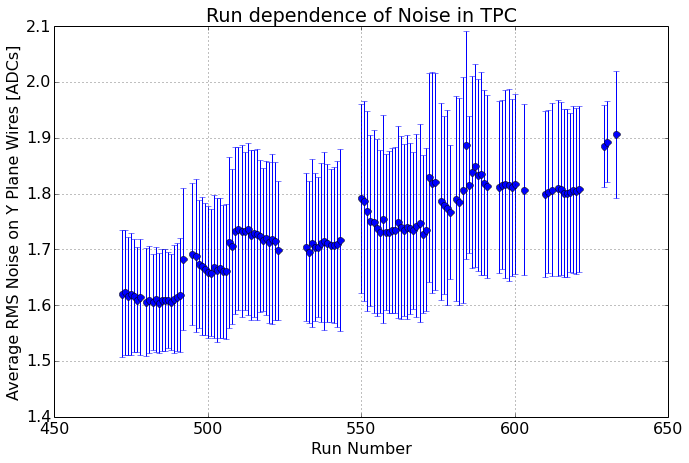

In [10]:
# plot noise value vs. run number for selected runs
plt.figure(figsize=(11,7))
plt.errorbar(runs_v,avg_v,yerr=rms_v,fmt='o',color='b',markersize=7)
plt.grid()
plt.xlabel('Run Number')
plt.ylabel('Average RMS Noise on Y Plane Wires [ADCs]')
plt.title('Run dependence of Noise in TPC')
plt.xlim([450,650])
plt.ylim([1.4,2.1])
plt.show()
#print runs_v

In [11]:
# figure out errors per fill by looking at distribution of data-points

# for each fill-level, take all runs that pass the cuts mentioned above
# take the distribution of average noise levels for all such runs
# the average of these averages is the "average noise level at a given fill-level"
# the std. deviation of these averages is taken as the error on this measurement

fill_noise_avg = []
fill_noise_rms = []
fill_level_avg = []
fill_level_rms = []
thisfill_noise = []
thisfill_level = []
lastlevel = levels_pure[0]

#levels_pure is the level for all "good" runs

for x in xrange(len(levels_pure)):
    
    # if we haven't changed lelvel yet keep appending to info for this fill-level
    if ( 100*(levels_pure[x]-lastlevel) < 10):
        thisfill_noise.append(ADCtoENC*avg_v_pure[x])
        thisfill_level.append(100*levels_pure[x])
        
    else:
        # calculate average and rms
        avg_level = np.average(np.array(thisfill_level))
        fill_level_avg.append(avg_level)
        avg_noise = np.average(np.array(thisfill_noise))
        fill_noise_avg.append(avg_noise)
        rms_level = np.std(np.array(thisfill_level))
        fill_level_rms.append(rms_level)
        rms_noise = np.std(np.array(thisfill_noise))
        fill_noise_rms.append(rms_noise)
        thisfill_noise = []
        thisfill_level = []
        
    lastlevel = levels_pure[x]
    
fill_noise_avg.append(ADCtoENC*avg_v_pure[-1])
fill_noise_rms.append(0)
fill_level_avg.append(100*levels_pure[-1])
fill_level_rms.append(1)

# find largest error on RMS:
fill_RMS = 0
for x in xrange(len(fill_noise_rms)):
    if (fill_noise_rms[x]/fill_noise_avg[x] > fill_RMS):
        fill_RMS = fill_noise_rms[x]/fill_noise_avg[x]
print 'The error on the fill-level RMS is %.02f'%fill_RMS

The error on the fill-level RMS is 0.01


In [12]:
# get fit to rms vs fill level (linear fit)
from scipy.optimize import curve_fit
def func(x,n,b):
    return b+m*x
#popt,popv = curve_fit(func,np.array(levels_p)*100,230*np.array(avg_v_p),sigma=230*np.array(rms_v_p))
popt,popv = curve_fit(func,np.array(fill_level_avg),np.array(fill_noise_avg),sigma=np.array(fill_noise_rms))
#popt,popv = curve_fit(func,[0,1,2,3,4,5],[2,3.1,3.9,5.2,6.0,6.8])
print popt
print popv
xarr = fill_level_avg
yarr = fill_noise_avg
z = np.polyfit(xarr,yarr,1)
f = np.poly1d(z)
print yarr
print f

[ 1.  1.]
inf
[371.11363755529578, 383.6650821951032, 394.21807142897086, 401.04477845064804, 414.39977038145065, 418.65641025866779, 439.7419550573826]
 
0.305 x + 366.6


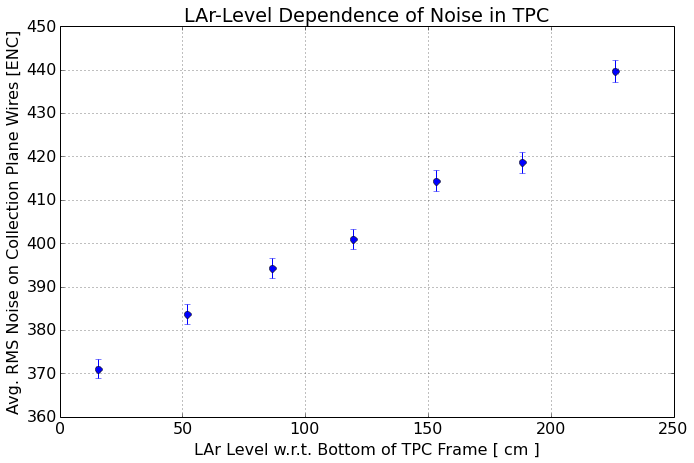

In [13]:
fig,ax = plt.subplots(figsize=(11,7))

plt.errorbar(fill_level_avg,fill_noise_avg,xerr=fill_level_rms,yerr=np.array(fill_noise_avg)*fill_RMS,\
             fmt='o',color='b',markersize=7,label='measured points')
xpts = np.linspace(0,250,100)
plt.grid()
ax.set_xlabel('LAr Level w.r.t. Bottom of TPC Frame [ cm ]')
#ax.set_ylabel('Avg. RMS Noise on Y Plane Wires [ADC]')
ax.set_ylabel('Avg. RMS Noise on Collection Plane Wires [ENC]')
plt.title('LAr-Level Dependence of Noise in TPC')
plt.savefig('noise_vs_fill_ENC_noFit_calculatedErrors.pdf')
plt.show()
#print time_v

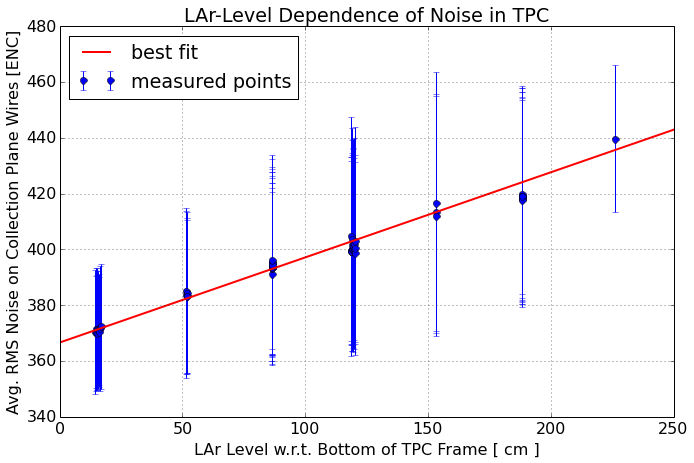

In [14]:
fig,ax = plt.subplots(figsize=(11,7))

plt.errorbar(np.array(levels_pure)*100,ADCtoENC*np.array(avg_v_pure),yerr=ADCtoENC*np.array(rms_v_pure),\
             fmt='o',color='b',markersize=7,label='measured points')
#plt.errorbar(np.array(levels_p)*100,np.array(avg_v_p),yerr=np.array(rms_v_p),fmt='o',color='b',markersize=7)
xpts = np.linspace(0,250,100)
plt.plot(xpts,f(xpts),color='r',lw=2,label='best fit')
#plt.plot(temps,avg_v)
#plt.errorbar(temps_IFIX192,avg_v,yerr=rms_v,fmt='o',color='b',markersize=7,label='IFIX 192')
#plt.errorbar(temps_TE856,avg_v,yerr=rms_v,fmt='o',color='r',markersize=7,label='TE 856 Temp')
plt.grid()
ax.set_xlabel('LAr Level w.r.t. Bottom of TPC Frame [ cm ]')
#ax.set_ylabel('Avg. RMS Noise on Y Plane Wires [ADC]')
ax.set_ylabel('Avg. RMS Noise on Collection Plane Wires [ENC]')
plt.title('LAr-Level Dependence of Noise in TPC')
plt.legend(loc=2)
#ax.invert_xaxis()
#plt.legend()
#plt.xlim([250,300])
#plt.ylim([2.0,2.2])
plt.show()
#print time_v

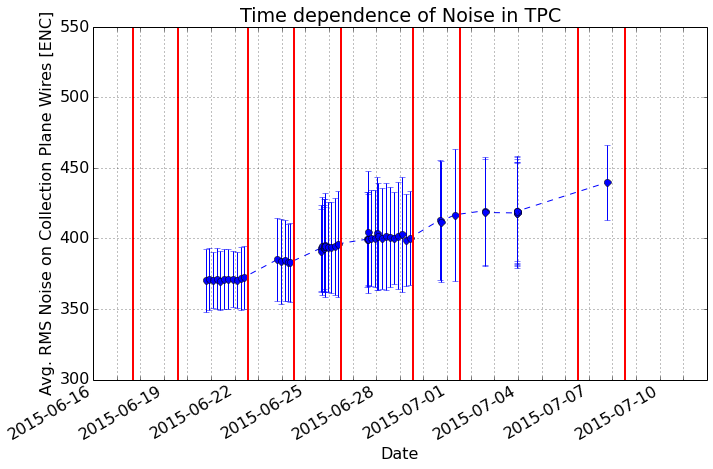

In [15]:
dates = dts.date2num(time_v_pure)

years    = dts.YearLocator()   # every year                                                                                                  
months   = dts.MonthLocator()  # every month                                                                                                 
days     = dts.DayLocator()
hours    = dts.HourLocator()
daysFmt  = dts.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(figsize=(11,7))
plt.errorbar(dates,ADCtoENC*np.array(avg_v_pure),yerr=ADCtoENC*np.array(rms_v_pure),fmt='o--',color='b',markersize=7)
#plt.errorbar(dates,np.array(avg_v),yerr=np.array(rms_v),fmt='o--',color='b',markersize=7)
for fill in filldates:
    plt.axvline(fill,color='r',lw=2)

plt.grid()
ax.set_xlim([datetime.datetime.strptime('2015/06/16','%Y/%m/%d'),
             datetime.datetime.strptime('2015/07/12','%Y/%m/%d')])
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
plt.xlabel('Date')
#plt.ylabel('Avg. RMS Noise on Y Plane Wires [ADC]')
plt.ylabel('Avg. RMS Noise on Collection Plane Wires [ENC]')
plt.title('Time dependence of Noise in TPC')
ax.format_xdata = dts.DateFormatter('%Y-%m-%d')

ctr = 0
for label in ax.xaxis.get_ticklabels():
    if (ctr%3 != 0):
        label.set_visible(False)
    ctr += 1
fig.autofmt_xdate()
plt.ylim([300,550])
plt.show()